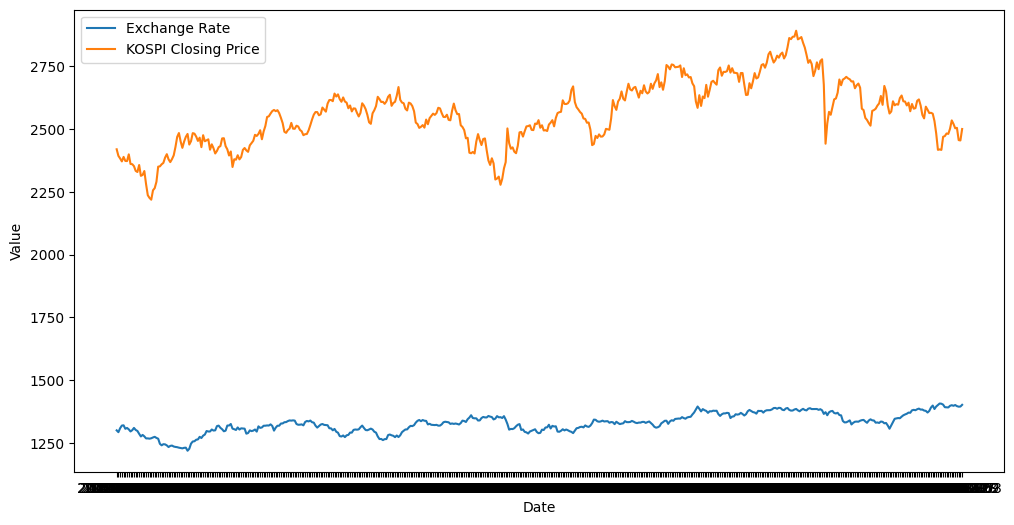

In [13]:
#모델링 및 실험

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np

# 데이터 병합 및 전처리
exchange_rate_df = pd.read_csv("C:/Users/유하민/git/exchange_rate_and_KOSPI/data/processed/processed_exchange_rate_data.csv")
kospi_data_df = pd.read_csv("C:/Users/유하민/git/exchange_rate_and_KOSPI/data/processed/processed_kospi_data.csv")

merged_df = pd.merge(exchange_rate_df, kospi_data_df, on='Date', how='inner')
merged_df = merged_df.sort_values(by='Date')

# 시계열 데이터 시각화
plt.figure(figsize=(12, 6))
plt.plot(merged_df['Date'], merged_df['Exchange_Rate'], label='Exchange Rate')
plt.plot(merged_df['Date'], merged_df['Closing_Price'], label='KOSPI Closing Price')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


Epoch 1/20
15/15 [==============================] - 28s 10ms/step - loss: 0.1147
Epoch 2/20
15/15 [==============================] - 0s 7ms/step - loss: 0.0186
Epoch 3/20
15/15 [==============================] - 0s 7ms/step - loss: 0.0116
Epoch 4/20
15/15 [==============================] - 0s 7ms/step - loss: 0.0084
Epoch 5/20
15/15 [==============================] - 0s 7ms/step - loss: 0.0070
Epoch 6/20
15/15 [==============================] - 0s 6ms/step - loss: 0.0067
Epoch 7/20
15/15 [==============================] - 0s 7ms/step - loss: 0.0066
Epoch 8/20
15/15 [==============================] - 0s 7ms/step - loss: 0.0062
Epoch 9/20
15/15 [==============================] - 0s 7ms/step - loss: 0.0061
Epoch 10/20
15/15 [==============================] - 0s 7ms/step - loss: 0.0061
Epoch 11/20
15/15 [==============================] - 0s 7ms/step - loss: 0.0059
Epoch 12/20
15/15 [==============================] - 0s 6ms/step - loss: 0.0059
Epoch 13/20
15/15 [============================

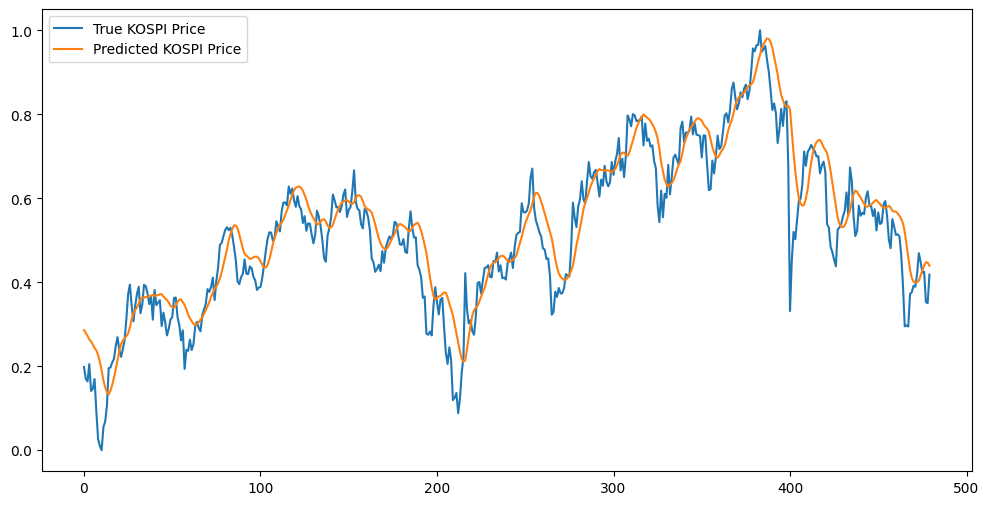

In [ ]:

# 데이터 스케일링
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(merged_df[['Exchange_Rate', 'Closing_Price']])

# LSTM 입력 준비 (이전 10일 데이터를 사용하여 다음날 예측)
X, y = [], []
for i in range(10, len(scaled_data)):
    X.append(scaled_data[i-10:i])
    y.append(scaled_data[i, 1])  # KOSPI 지수 예측

X, y = np.array(X), np.array(y)

# LSTM 모델 정의
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=30, batch_size=32)

# 예측 결과 시각화
predictions = model.predict(X)
plt.figure(figsize=(12, 6))
plt.plot(y, label='True KOSPI Price')
plt.plot(predictions, label='Predicted KOSPI Price')
plt.legend()
plt.show()
